# Multi-Modal Deep Reinforcement Learning for Algorithmic Trading

Danica Bellchambers  
Sean Fuller 

In [4]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

import itertools

# PART 1: Traditional Data Only - Technical Indicators

## Fetch data

In [9]:
config_tickers.DOW_30_TICKER

['AXP',
 'AMGN',
 'AAPL',
 'BA',
 'CAT',
 'CSCO',
 'CVX',
 'GS',
 'HD',
 'HON',
 'IBM',
 'INTC',
 'JNJ',
 'KO',
 'JPM',
 'MCD',
 'MMM',
 'MRK',
 'MSFT',
 'NKE',
 'PG',
 'TRV',
 'UNH',
 'CRM',
 'VZ',
 'V',
 'WBA',
 'WMT',
 'DIS',
 'DOW']

In [10]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [11]:
df_raw = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [12]:
df_raw.head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.751009,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,43.073925,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.256275,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.254068,7117200,CAT,4


## Preprocessing

In [13]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_vix=True,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3228, 8)
Successfully added vix
Successfully added turbulence index


In [14]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [15]:
processed_full.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.751009,746015200.0,4.0,0.0,2.973257,2.644865,100.0,66.666667,100.0,2.751009,2.751009,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.073925,6547900.0,4.0,0.0,2.973257,2.644865,100.0,66.666667,100.0,43.073925,43.073925,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.256275,10955700.0,4.0,0.0,2.973257,2.644865,100.0,66.666667,100.0,15.256275,15.256275,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.973257,2.644865,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.254068,7117200.0,4.0,0.0,2.973257,2.644865,100.0,66.666667,100.0,31.254068,31.254068,39.189999,0.0


## Split and Save Dataset

In [16]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83897
9715


In [17]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

---
---

# PART 2: NLP and Sentiment Data Modeling

## NLP Data Collection

See `async_multithread_data_puller.py` for the web-scraping code. 
This notebook is run once that data is pulled but not yet processed.

## Calculation of New Features
* story_count (prior day)
* sentiment (prior day)
* combined_metric (prior day sentiment * prior day story count)
* 4_day_avg_sentiment
* 10_day_avg_sentiment

In [ ]:
from tqdm.notebook import tqdm
from transformers import DeBertForSequenceClassification, BertTokenizer
import torch
from torch.nn.functional import softmax

In [ ]:
import os
# os.chdir('/Users/seanfuller/Code/msds-local/464/Final_Project/FinNLP/data_dir')
import pandas as pd
# full_initial = pd.read_csv('data_FULL_TIME_FRAME_00.csv')
import warnings
warnings.filterwarnings('ignore')

# sorted(csv_files['fn_year'].astype(int).unique().tolist())
# print(pd.to_datetime(data.time).min())
# print(pd.to_datetime(data.time).max())

## Stories 
(scraped in .CSVs)

In [ ]:
# get a list of all the csv files in the data_dir
csv_files = [f[:-4] for f in os.listdir() if f.endswith('.csv')]

# remove periods from the file names
csv_files = [f.replace('.', '') for f in csv_files]
# split on _
csv_files = [f.split('_') for f in csv_files]
# make a dataframe of these three columns (which are called `ticker, `fn_month`, and `fn_year`)
csv_files = pd.DataFrame(csv_files, columns=['ticker', 'fn_month', 'fn_year'])
# add a column to csv_files called `file_name` which is the original file name
csv_files['file_name'] = [f  for f in os.listdir() if f.endswith('.csv')]
csv_files['month_year'] = csv_files['fn_month'] + '_' + csv_files['fn_year']
# get a list of the unique tickers and unique month_year combinations
tickers = csv_files.ticker.unique()
month_years = csv_files.month_year.unique()
csv_files

,ticker,fn_month,fn_year,file_name,month_year
0,JPM,Oct,2013,JPM_Oct._2013.csv,Oct_2013
1,INTC,Jul,2018,INTC_Jul._2018.csv,Jul_2018
2,MSFT,Oct,2019,MSFT_Oct._2019.csv,Oct_2019
3,MCD,Jun,2011,MCD_Jun._2011.csv,Jun_2011
4,GS,Mar,2011,GS_Mar._2011.csv,Mar_2011
...,...,...,...,...,...
4276,GS,Mar,2020,GS_Mar._2020.csv,Mar_2020
4277,INTC,Jul,2015,INTC_Jul._2015.csv,Jul_2015
4278,AAPL,May,2013,AAPL_May_2013.csv,May_2013
4279,MSFT,Oct,2014,MSFT_Oct._2014.csv,Oct_2014


Extract them into a df and clean them

In [ ]:
data_dir_path = "."
data = pd.read_csv(os.path.join(data_dir_path, "../data_FULL_TIME_FRAME_00.csv"))
data2 = data.head(1).copy()
for _, row in csv_files.iterrows():
    file_path = f"{data_dir_path}/{row['file_name']}"
    temp_data = pd.read_csv(file_path)
    temp_data['ticker'] = row['ticker']
    temp_data['fn_month'] = row['fn_month']
    temp_data['fn_year'] = row['fn_year']
    data2 = pd.concat([data2, temp_data], ignore_index=True)

data2.drop(0, inplace=True)
data2.reset_index(drop=True, inplace=True)
data2
data = data2.copy()
data['title_clean'] = data['title'].str.replace('[^a-zA-Z\s]', '').str.lower()
data

,title,time,author,Ticker/Keyword,ticker,fn_month,fn_year,title_clean
0,Musical chairs means somebody loses,"Oct. 1, 2013 at 2:46 p.m. ET",by Cody Willard,JPM,JPM,Oct,2013,musical chairs means somebody loses
1,"Bank stocks edge up, while earnings hopes are low","Oct. 1, 2013 at 9:58 a.m. ET",by Christina Rexrode,JPM,JPM,Oct,2013,"bank stocks edge up, while earnings hopes are low"
2,"Financials slip, Wells Fargo sued over mortgages","Oct. 2, 2013 at 12:44 p.m. ET",by Sital S. Patel,JPM,JPM,Oct,2013,"financials slip, wells fargo sued over mortgages"
3,Dimon: Timing of White House meeting not awkward,"Oct. 2, 2013 at 11:42 a.m. ET",by Greg Robb,JPM,JPM,Oct,2013,dimon: timing of white house meeting not awkward
4,"Goldman, Morgan and J.P Morgan lead Twitter IPO","Oct. 3, 2013 at 5:34 p.m. ET",by Sital S. Patel,JPM,JPM,Oct,2013,"goldman, morgan and j.p morgan lead twitter ipo"
...,...,...,...,...,...,...,...,...
189657,Time to Break Up P&G? This Man Thinks So,"May. 14, 2016 at 12:01 a.m. ET",by Barron's,PG,PG,May,2016,time to break up p&g? this man thinks so
189658,Apple's stock surges after Warren Buffett disc...,"May. 16, 2016 at 7:56 a.m. ET",by Tomi Kilgore,PG,PG,May,2016,apple's stock surges after warren buffett disc...
189659,In focus: The spring is coiling,"May. 18, 2016 at 10:12 p.m. ET",by Lawrence G. McMillan,PG,PG,May,2016,in focus: the spring is coiling
189660,Activist investors ally to form lobby group,"May. 19, 2016 at 6:39 a.m. ET",by David Benoit,PG,PG,May,2016,activist investors ally to form lobby group


### Remove highly duplicated titles

In [ ]:
title_counts = data.title.value_counts().to_frame().reset_index()
kept_titles = title_counts.loc[(title_counts['count'] <= 40), 'title'].tolist()
data = data.loc[data['title'].isin(kept_titles)]
data

,title,time,author,Ticker/Keyword,ticker,fn_month,fn_year,title_clean
0,Musical chairs means somebody loses,"Oct. 1, 2013 at 2:46 p.m. ET",by Cody Willard,JPM,JPM,Oct,2013,musical chairs means somebody loses
1,"Bank stocks edge up, while earnings hopes are low","Oct. 1, 2013 at 9:58 a.m. ET",by Christina Rexrode,JPM,JPM,Oct,2013,"bank stocks edge up, while earnings hopes are low"
2,"Financials slip, Wells Fargo sued over mortgages","Oct. 2, 2013 at 12:44 p.m. ET",by Sital S. Patel,JPM,JPM,Oct,2013,"financials slip, wells fargo sued over mortgages"
3,Dimon: Timing of White House meeting not awkward,"Oct. 2, 2013 at 11:42 a.m. ET",by Greg Robb,JPM,JPM,Oct,2013,dimon: timing of white house meeting not awkward
4,"Goldman, Morgan and J.P Morgan lead Twitter IPO","Oct. 3, 2013 at 5:34 p.m. ET",by Sital S. Patel,JPM,JPM,Oct,2013,"goldman, morgan and j.p morgan lead twitter ipo"
...,...,...,...,...,...,...,...,...
189657,Time to Break Up P&G? This Man Thinks So,"May. 14, 2016 at 12:01 a.m. ET",by Barron's,PG,PG,May,2016,time to break up p&g? this man thinks so
189658,Apple's stock surges after Warren Buffett disc...,"May. 16, 2016 at 7:56 a.m. ET",by Tomi Kilgore,PG,PG,May,2016,apple's stock surges after warren buffett disc...
189659,In focus: The spring is coiling,"May. 18, 2016 at 10:12 p.m. ET",by Lawrence G. McMillan,PG,PG,May,2016,in focus: the spring is coiling
189660,Activist investors ally to form lobby group,"May. 19, 2016 at 6:39 a.m. ET",by David Benoit,PG,PG,May,2016,activist investors ally to form lobby group


In [ ]:
# data.to_csv('nlp_data.csv', index=False)

## Apply the fine-tuned NLU model to get a sentiment score for each story

In [ ]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model and tokenizer
# See github.com/sfuller14/DeBERTa_Entity-Focused_Fine-Tuning.git
model_name = "sfuller14/financial-text-deberta"
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)  # Move model to device
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

# Tokenize the titles in batches and get predictions
batch_size = 128  
sentiments = []

for i in tqdm(range(0, len(data['title_clean']), batch_size)):
    batch = data['title_clean'].iloc[i:i+batch_size].tolist()
    inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}  # Move data to device
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = softmax(logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1)
    sentiments.extend(predicted_class.cpu().numpy())  # Move data back to CPU

data['sentiment'] = sentiments

  0%|          | 0/1465 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Add prediction to `data` for date- and token-specific sentiment score aggregation

In [ ]:
data.sentiment.value_counts()

0    101193
1     47010
2     39198
Name: sentiment, dtype: int64

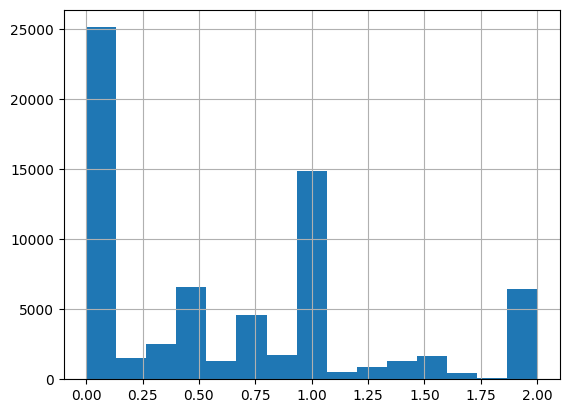

In [ ]:
sentiment_summary = data.groupby(['date', 'ticker'])['sentiment'].mean().reset_index()

sentiment_summary.sentiment.hist(
    bins=15
);

In [ ]:
# Plot rolling average sentiment for AAPL
sentiment_summary.groupby('ticker')['sentiment'].mean().sort_values(ascending=False)


ticker
CVX     0.820402
TRV     0.780322
HON     0.742106
BA      0.725382
CSCO    0.706837
AXP     0.697645
INTC    0.690306
AAPL    0.651994
WMT     0.651285
UNH     0.645274
MMM     0.643936
WBA     0.637432
NKE     0.636636
IBM     0.635801
CAT     0.634913
JPM     0.634256
V       0.633052
HD      0.628773
MSFT    0.617540
GS      0.617176
MRK     0.610191
VZ      0.594137
PG      0.589547
KO      0.588460
AMGN    0.585609
CRM     0.580104
MCD     0.580060
JNJ     0.566820
DIS     0.494239
Name: sentiment, dtype: float64

In [ ]:
sentiment_summary.to_excel('sentiment_summary.xlsx')
data.to_excel('sentiment_data.xlsx')

# PART 3: Building Sentiment Features into the RL Datasets

In [18]:
train_data = pd.read_csv('train_data.csv')
print(f'{train_data.shape}')
trade_data = pd.read_csv('trade_data.csv')
print(f'{trade_data.shape}')

(83897, 19)
(9715, 19)


In [ ]:
# PART 3: 

In [19]:
sentiment_data = pd.read_excel('sentiment_summary.xlsx')
sentiment_data = sentiment_data[['date','sentiment','ticker']]
sentiment_data

,date,sentiment,ticker
0,1998-03-30,0.000000,DIS
1,1998-03-30,0.000000,IBM
2,1998-03-30,0.000000,KO
3,1998-03-30,0.000000,MCD
4,1998-03-30,0.000000,MSFT
...,...,...,...
69588,2021-10-26,1.000000,V
69589,2021-10-26,1.000000,WBA
69590,2021-10-27,2.000000,CVX
69591,2021-10-27,1.200000,INTC


In [21]:
# Extract unique tickers from sentiment dataset
sentiment_tickers = set(sentiment_data['ticker'].unique())

# Combine the two datasets to get a comprehensive list of tickers
combined_rl_data = pd.concat([train_data, trade_data], axis=0)
rl_tickers = set(combined_rl_data['tic'].unique())

# Identify tickers that are in the RL dataset but not in the sentiment dataset, and vice versa
missing_in_sentiment = rl_tickers - sentiment_tickers
missing_in_rl = sentiment_tickers - rl_tickers

missing_in_sentiment, missing_in_rl

(set(), set())

In [22]:
nlp_data = pd.read_csv('../FinNLP/data_dir/nlp_data.csv')
nlp_data

,title,time,author,Ticker/Keyword,ticker,fn_month,fn_year,title_clean
0,Musical chairs means somebody loses,"Oct. 1, 2013 at 2:46 p.m. ET",by Cody Willard,JPM,JPM,Oct,2013,musical chairs means somebody loses
1,"Bank stocks edge up, while earnings hopes are low","Oct. 1, 2013 at 9:58 a.m. ET",by Christina Rexrode,JPM,JPM,Oct,2013,"bank stocks edge up, while earnings hopes are low"
2,"Financials slip, Wells Fargo sued over mortgages","Oct. 2, 2013 at 12:44 p.m. ET",by Sital S. Patel,JPM,JPM,Oct,2013,"financials slip, wells fargo sued over mortgages"
3,Dimon: Timing of White House meeting not awkward,"Oct. 2, 2013 at 11:42 a.m. ET",by Greg Robb,JPM,JPM,Oct,2013,dimon: timing of white house meeting not awkward
4,"Goldman, Morgan and J.P Morgan lead Twitter IPO","Oct. 3, 2013 at 5:34 p.m. ET",by Sital S. Patel,JPM,JPM,Oct,2013,"goldman, morgan and j.p morgan lead twitter ipo"
...,...,...,...,...,...,...,...,...
187396,Time to Break Up P&G? This Man Thinks So,"May. 14, 2016 at 12:01 a.m. ET",by Barron's,PG,PG,May,2016,time to break up p&g? this man thinks so
187397,Apple's stock surges after Warren Buffett disc...,"May. 16, 2016 at 7:56 a.m. ET",by Tomi Kilgore,PG,PG,May,2016,apple's stock surges after warren buffett disc...
187398,In focus: The spring is coiling,"May. 18, 2016 at 10:12 p.m. ET",by Lawrence G. McMillan,PG,PG,May,2016,in focus: the spring is coiling
187399,Activist investors ally to form lobby group,"May. 19, 2016 at 6:39 a.m. ET",by David Benoit,PG,PG,May,2016,activist investors ally to form lobby group


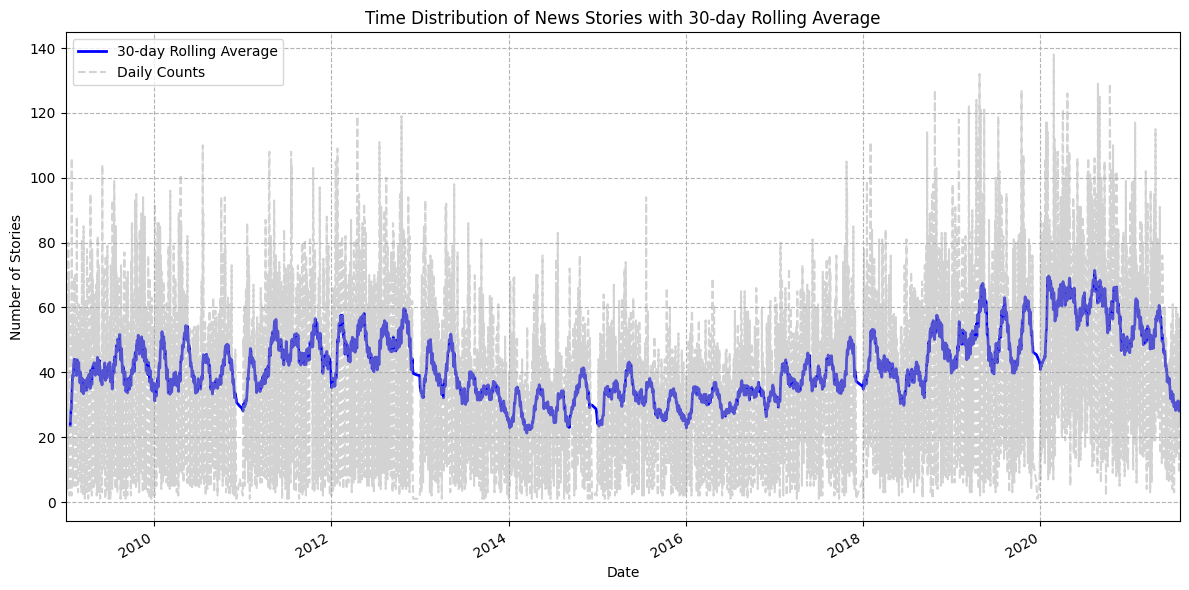

In [ ]:
df = pd.DataFrame(nlp_data)

# Group by date and count the number of stories
time_distribution = df.groupby('date').size()

# Calculate the rolling average over a 30-day window
rolling_avg = time_distribution.rolling(window=30).mean()

# Plot
plt.figure(figsize=(12, 6))
rolling_avg.plot(linewidth=2, color='blue', label='30-day Rolling Average')
time_distribution.plot(alpha=0.5, linestyle='dashed', color='darkgray', label='Daily Counts')
plt.title('Time Distribution of News Stories with 30-day Rolling Average')
plt.xlabel('Date')
plt.ylabel('Number of Stories')
plt.grid(True, which="both", ls="--", c='0.7')
plt.tight_layout()
plt.legend()
# start in 2009 on the x axis
plt.xlim([datetime.date(2009, 1, 1), datetime.date(2021, 7, 29)])
plt.show()


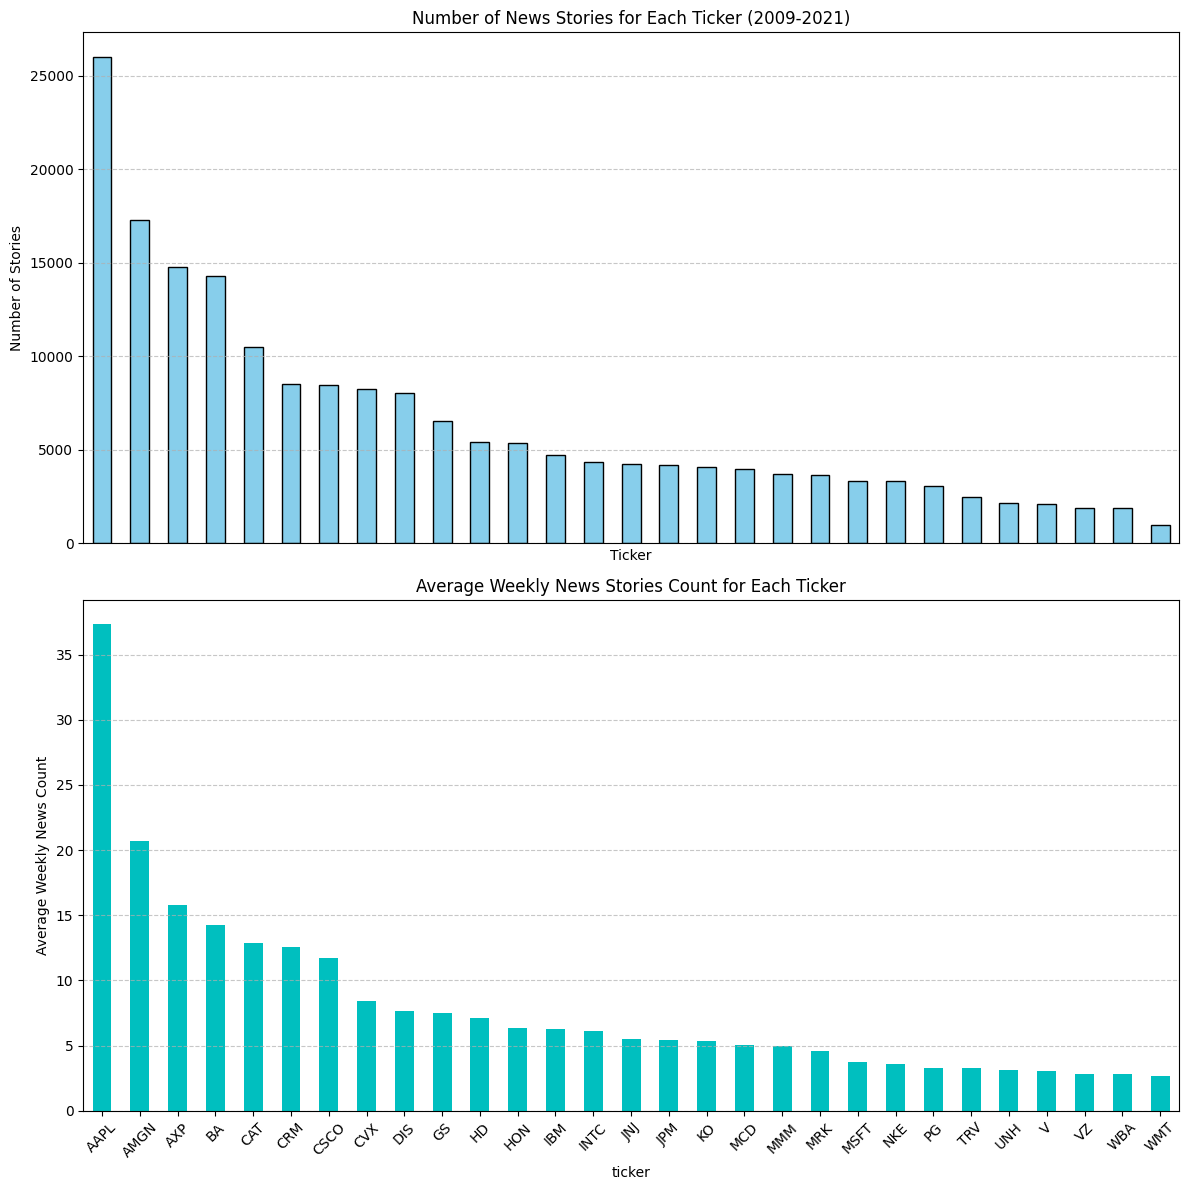

In [54]:
ticker_counts = nlp_data.groupby('ticker').size().sort_values(ascending=False)

# Setting up the subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# Plotting the total count bar chart
ticker_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax[0])
ax[0].set_title('Number of News Stories for Each Ticker (2009-2021)')
ax[0].set_ylabel('Number of Stories')
ax[0].set_xlabel('Ticker')
ax[0].set_xticks([])  # Hide x-ticks for the top plot for clarity
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Group by 'ticker' and resample by week, then count the number of stories per week
weekly_counts = nlp_data.groupby('ticker').resample('W-Mon', on='date').size().reset_index(name='weekly_count')

# Calculate the mean weekly count for each ticker
avg_weekly_counts = weekly_counts.groupby('ticker')['weekly_count'].mean().reset_index()

# Plotting the average weekly counts bar chart
avg_weekly_counts.set_index('ticker')['weekly_count'].sort_values(ascending=False).plot(kind='bar', color='c', ax=ax[1])
ax[1].set_ylabel('Average Weekly News Count')
ax[1].set_title('Average Weekly News Stories Count for Each Ticker')
ax[1].set_xticks(range(len(avg_weekly_counts)))  # Set x-ticks
ax[1].set_xticklabels(avg_weekly_counts['ticker'], rotation=45)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [25]:
story_count['date']=pd.to_datetime(story_count['date'])
# drop days in story count prior to 2009
story_count = story_count[story_count['date'] >= pd.to_datetime(combined_rl_data.date).min()]
# do the same for sentiment data
sentiment_data = sentiment_data[sentiment_data['date'] >= pd.to_datetime(combined_rl_data.date).min()]
# Correcting the column name for merging

# Convert the 'date' column in train_data and trade_data to datetime format
train_data['date'] = pd.to_datetime(train_data['date'])
trade_data['date'] = pd.to_datetime(trade_data['date'])

# Merge the sentiment data with the RL datasets based on date and tic
train_data = pd.merge(train_data, sentiment_data, left_on=['date', 'tic'], right_on=['date', 'ticker'], how='left')
trade_data = pd.merge(trade_data, sentiment_data, left_on=['date', 'tic'], right_on=['date', 'ticker'], how='left')

# Drop the redundant ticker column from the merged data
train_data.drop(columns=['ticker'], inplace=True)
trade_data.drop(columns=['ticker'], inplace=True)

# Fill missing sentiment data with neutral value
train_data['sentiment'] = train_data['sentiment'].fillna(0)
trade_data['sentiment'] = trade_data['sentiment'].fillna(0)

# Calculate rolling averages for sentiment over lookback windows
train_data['4_day_avg_sentiment'] = train_data.groupby('tic')['sentiment'].transform(lambda x: x.rolling(window=4).mean())
train_data['10_day_avg_sentiment'] = train_data.groupby('tic')['sentiment'].transform(lambda x: x.rolling(window=10).mean())

trade_data['4_day_avg_sentiment'] = trade_data.groupby('tic')['sentiment'].transform(lambda x: x.rolling(window=4).mean())
trade_data['10_day_avg_sentiment'] = trade_data.groupby('tic')['sentiment'].transform(lambda x: x.rolling(window=10).mean())

# Merge story count data with RL datasets based on date and tic
train_data = pd.merge(train_data, story_count, left_on=['date', 'tic'], right_on=['date', 'ticker'], how='left')
trade_data = pd.merge(trade_data, story_count, left_on=['date', 'tic'], right_on=['date', 'ticker'], how='left')

# Drop the redundant ticker column from the merged data
train_data.drop(columns=['ticker'], inplace=True)
trade_data.drop(columns=['ticker'], inplace=True)

# Fill missing story counts with 0
train_data['story_count'] = train_data['story_count'].fillna(0)
trade_data['story_count'] = trade_data['story_count'].fillna(0)

# Combine prior day's story count with prior day sentiment
train_data['combined_metric'] = train_data['sentiment'].shift(1) * train_data['story_count'].shift(1)
trade_data['combined_metric'] = trade_data['sentiment'].shift(1) * trade_data['story_count'].shift(1)

# Fill NaN values introduced by shifting operation
train_data['combined_metric'] = train_data['combined_metric'].fillna(0)
trade_data['combined_metric'] = trade_data['combined_metric'].fillna(0)

train_data.drop(columns=['Unnamed: 0'], inplace=True)
train_data.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,dx_30,close_30_sma,close_60_sma,vix,turbulence,sentiment,4_day_avg_sentiment,10_day_avg_sentiment,story_count,combined_metric
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.751009,746015200.0,4.0,0.0,2.973257,...,100.0,2.751009,2.751009,39.189999,0.0,1.0,NaN,NaN,3.0,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.073925,6547900.0,4.0,0.0,2.973257,...,100.0,43.073925,43.073925,39.189999,0.0,0.0,NaN,NaN,0.0,3.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.256275,10955700.0,4.0,0.0,2.973257,...,100.0,15.256275,15.256275,39.189999,0.0,0.0,NaN,NaN,0.0,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.973257,...,100.0,33.941101,33.941101,39.189999,0.0,0.0,NaN,NaN,0.0,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.254068,7117200.0,4.0,0.0,2.973257,...,100.0,31.254068,31.254068,39.189999,0.0,0.0,NaN,NaN,1.0,0.0


In [26]:
# Fill in 10-day trailing average gap at beginning of dataset
train_data.fillna(0, inplace=True)
trade_data.fillna(0, inplace=True)

In [27]:
train_data.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,...,dx_30,close_30_sma,close_60_sma,vix,turbulence,sentiment,4_day_avg_sentiment,10_day_avg_sentiment,story_count,combined_metric
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.751009,746015200.0,4.0,0.0,2.973257,...,100.0,2.751009,2.751009,39.189999,0.0,1.0,0.0,0.0,3.0,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,43.073925,6547900.0,4.0,0.0,2.973257,...,100.0,43.073925,43.073925,39.189999,0.0,0.0,0.0,0.0,0.0,3.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.256275,10955700.0,4.0,0.0,2.973257,...,100.0,15.256275,15.256275,39.189999,0.0,0.0,0.0,0.0,0.0,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,2.973257,...,100.0,33.941101,33.941101,39.189999,0.0,0.0,0.0,0.0,0.0,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.254068,7117200.0,4.0,0.0,2.973257,...,100.0,31.254068,31.254068,39.189999,0.0,0.0,0.0,0.0,1.0,0.0


## Save new dataset

In [28]:
train_data.to_csv('train_data_augmented.csv')
trade_data.to_csv('trade_data_augmented.csv')

# PART 4: NLP-AUGMENTED Training
Use that dataset that was just created to train the RL model with sentiment state  info

In [ ]:
train = pd.read_csv('train_data_augmented.csv')
# train_old = pd.read_csv('train_data.csv')

In [ ]:
from stable_baselines3 import A2C

train = pd.read_csv('train_data_augmented.csv')
train = train.set_index(train.columns[0])
train.index.names = ['']

stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

Stock Dimension: 29, State Space: 291
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


Train DRL Agents

In [ ]:
agent = DRLAgent(env = env_train)

# Set the corresponding values to 'True' for the algorithms that you want to use
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c_augmented")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c_augmented'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [ ]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c_augmented',
                             total_timesteps=50000) if if_using_a2c else None

---------------------------------------
| time/                 |             |
|    fps                | 59          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -41.3       |
|    explained_variance | 0.453       |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 18.2        |
|    reward             | -0.18390413 |
|    std                | 1           |
|    value_loss         | 0.684       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 73         |
|    iterations         | 200        |
|    time_elapsed       | 13         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    lear

In [ ]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c_augmented") if if_using_a2c else None

### Agent 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 60       |
|    time_elapsed    | 190      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | -52.2    |
|    critic_loss     | 1.18e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 6.205496 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 50       |
|    time_elapsed    | 461      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 32.8     |
|    critic_loss     | 67.3     |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward          | 6.205496 |
---------------------------------
day: 2892, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5300085.61
total_reward: 4300085.61
total_cost

In [ ]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg_augmented") if if_using_ddpg else None

### Agent 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

In [ ]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 93        |
|    iterations      | 1         |
|    time_elapsed    | 21        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2830317 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 89          |
|    iterations           | 2           |
|    time_elapsed         | 45          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017405685 |
|    clip_fraction        | 0.198       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.00116     |
|    learning_rate        | 0.00025     |
|    loss                 | 4.47        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0175     |
|    reward  

In [ ]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo_augmented") if if_using_ppo else None

### Agent 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100,
              "buffer_size": 1000000,
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

In [ ]:
trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 56       |
|    time_elapsed    | 205      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 131      |
|    critic_loss     | 2.03e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 6.152368 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 49       |
|    time_elapsed    | 464      |
|    total_timesteps | 23144    |
| train/             |          |
|    actor_loss      | 47.2     |
|    critic_loss     | 514      |
|    learning_rate   | 0.001    |
|    n_updates       | 20251    |
|    reward          | 6.152368 |
---------------------------------
day: 2892, episode: 100
begin_total_asset: 1000000.00
end_total_asset: 4926169.58
total_reward: 3926169.58
total_cos

In [ ]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3_augmented") if if_using_td3 else None

### Agent 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

In [ ]:
trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac_augmented',
                             total_timesteps=70000) if if_using_sac else None

day: 2892, episode: 110
begin_total_asset: 1000000.00
end_total_asset: 5750972.63
total_reward: 4750972.63
total_cost: 14673.96
total_trades: 45125
Sharpe: 0.930
----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 40        |
|    time_elapsed    | 285       |
|    total_timesteps | 11572     |
| train/             |           |
|    actor_loss      | 821       |
|    critic_loss     | 96.7      |
|    ent_coef        | 0.146     |
|    ent_coef_loss   | -92.5     |
|    learning_rate   | 0.0001    |
|    n_updates       | 11471     |
|    reward          | 3.4856157 |
----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 40         |
|    time_elapsed    | 573        |
|    total_timesteps | 23144      |
| train/             |            |
|    actor_loss      | 369        |
|    critic_loss     | 49

In [ ]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac_augmented") if if_using_sac else None

# Part 5: Backtesting

In [ ]:
SENTIMENT = True

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

%matplotlib inline

In [ ]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [ ]:
if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

Load the agents

In [ ]:
if not SENTIMENT:
    trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
    trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
    trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
    trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
    trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None
##
else:
    trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c_augmented") if if_using_a2c else None
    trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg_augmented") if if_using_ddpg else None
    trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo_augmented") if if_using_ppo else None
    trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3_augmented") if if_using_td3 else None
    trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac_augmented") if if_using_sac else None
##

### Trading (aka Test Set)

In [ ]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

In [ ]:
# Part 3: Mean Variance Optimization
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")
### Helper functions for mean returns and variance-covariance matrix
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [ ]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

<!-- ### Use PyPortfolioOpt -->

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

# ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
# raw_weights_mean = ef_mean.max_sharpe()
# cleaned_weights_mean = ef_mean.clean_weights()
# mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))])
# mvo_weights
# LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
# Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
# Initial_Portfolio
# Portfolio_Assets = TradeData @ Initial_Portfolio
# MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

<!-- # Part 4: DJIA index -->

In [ ]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-10-29'

In [ ]:
# df_dji = YahooDownloader(
#     start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["dji"]
# ).fetch_data()

In [ ]:
# df_dji = df_dji[["date", "close"]]
# fst_day = df_dji["close"][0]
# dji = pd.merge(
#     df_dji["date"],
#     df_dji["close"].div(fst_day).mul(1000000),
#     how="outer",
#     left_index=True,
#     right_index=True,
# ).set_index("date")

## Results -- 

In [ ]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
        "mvo": MVO_result["Mean Var"],
        "dji": dji["close"],
    }
)

plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [ ]:
# result.to_csv('result_ds_orig.csv')
result

,a2c,ddpg,ppo,td3,sac,mvo,dji
date,,,,,,,
2020-07-01,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.000000e+06,1.001918e+06,1.000000e+06
2020-07-02,1.000903e+06,1.000571e+06,1.000260e+06,1.000373e+06,1.000472e+06,1.004235e+06,NaN
2020-07-06,1.006918e+06,1.006886e+06,1.002261e+06,1.006187e+06,1.006336e+06,1.023225e+06,1.021449e+06
2020-07-07,9.952538e+05,9.970184e+05,9.986101e+05,9.964528e+05,1.000186e+06,1.014021e+06,1.006031e+06
2020-07-08,1.000623e+06,1.000125e+06,9.998931e+05,1.000698e+06,1.005490e+06,1.029461e+06,1.012912e+06
...,...,...,...,...,...,...,...
2021-10-22,1.432664e+06,1.323908e+06,1.349163e+06,1.519340e+06,1.482928e+06,1.535668e+06,1.386322e+06
2021-10-25,1.434896e+06,1.326463e+06,1.361277e+06,1.522877e+06,1.488541e+06,1.542078e+06,1.388813e+06
2021-10-26,1.437446e+06,1.325783e+06,1.356732e+06,1.520465e+06,1.487688e+06,1.545514e+06,1.389427e+06


## Results - No Sentiment Augmentation

<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

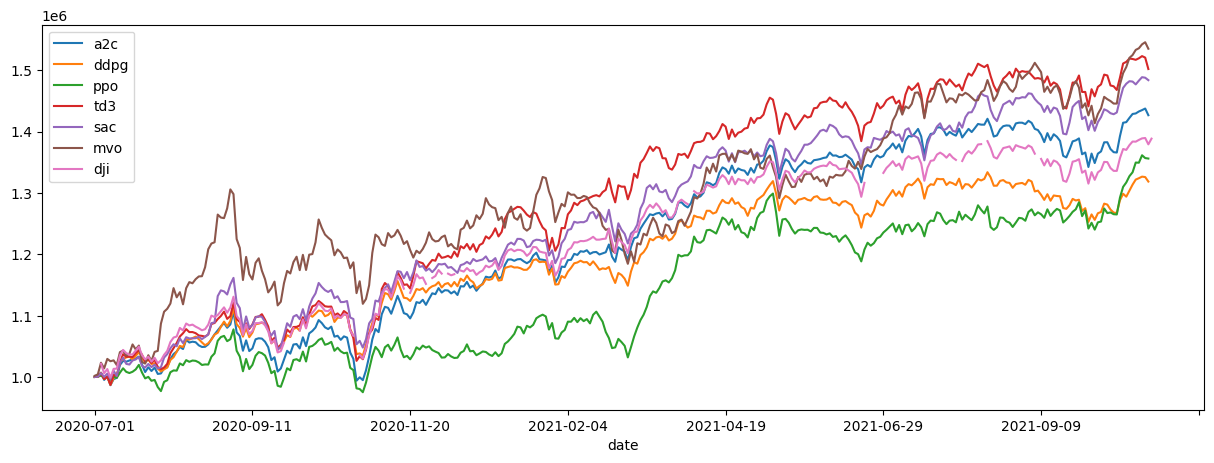

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

In [ ]:
# Convert the Series to a DataFrame
df = data_at_date.to_frame(name='Ending Value')

# Calculate each model's values minus dji's value
df['Dollar_Gain'] = (df['Ending Value'] - 1000000).round(2)
df['Excess Return ($)'] = (df['Ending Value'] - df.loc['dji', 'Ending Value']).round(2)
df['Ending Value'] = df['Ending Value'].astype(int)
# Calculate ending value - 1000000
df['Gain'] = df['Dollar_Gain']/1000000
df['Gain  (%)'] = (df['Gain'] * 100).round(2)

# Drop the mvo row
df.sort_values(by='Gain  (%)', ascending=False, inplace=True)
df


,Ending Value,Dollar_Gain,Excess Return ($),Gain,Gain (%)
mvo,1534915,534915.68,155832.75,0.534916,53.49
td3,1501826,501826.50,122743.56,0.501826,50.18
sac,1483698,483698.53,104615.60,0.483699,48.37
a2c,1426574,426574.65,47491.72,0.426575,42.66
dji,1379082,379082.93,0.00,0.379083,37.91
ppo,1355946,355946.44,-23136.49,0.355946,35.59
ddpg,1318446,318446.68,-60636.25,0.318447,31.84


| Model | Ending Value       | Dollar Gain | Excess Return ($) | Gain (%) |
|-------|--------------------|-------------|-------------------|----------|
| **<u>MVO</u>**  | \$1,534,920        | \$534,916   | \$155,833         | 53.49%   |
| TD3  | \$1,501,830        | \$501,826   | \$122,744         |  50.18%   |
| SAC  | \$1,483,700        | \$483,699   | \$104,616         |  48.37%   |
| A2C  | \$1,426,570        | \$426,575   | \$47,491.7        |  42.66%   |
| DJI  | \$1,379,080        | \$379,083   | \$0               |  37.91%   |
| PPO  | \$1,355,950        | \$355,946   | -\$23,136.5       |  35.59%   |
| DDPG | \$1,318,450        | \$318,447   | -\$60,636.2       |  31.84%   |

# Web Scraping Script for Financial News Articles

In [ ]:
# NOTE: Use of ThreadPoolExecutor with the async calls will likely result in major rate limiting unless a proxy is used

import datetime
import pandas as pd
import asyncio
from datetime import timedelta
from finnlp.data_sources.news.marketwatch_date_range import MarketWatch_Date_Range
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import os

tickers = ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 
           'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 
           'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 
           'UNH', 'V', 'VZ', 'WBA', 'WMT']

start_date = datetime.datetime(2009, 1, 1)
end_date = datetime.datetime(2021, 10, 27)

all_dataframes = []
month_dataframes = []
last_month = start_date.month
months = {
    1: 'Jan.',
    2: 'Feb.',
    3: 'Mar.',
    4: 'Apr.',
    5: 'May',
    6: 'Jun.',
    7: 'Jul.',
    8: 'Aug.',
    9: 'Sep.',
    10: 'Oct.',
    11: 'Nov.',
    12: 'Dec.'
}

async def fetch_data_for_date(date, keyword):
    date_str = date.strftime('%Y-%m-%d')
    downloader = MarketWatch_Date_Range()
    downloader.download_date_range_search(start_date=date_str, end_date=date_str, keyword=keyword)
    df = downloader.dataframe
    df["Ticker/Keyword"] = keyword
    return df

async def fetch_data_for_ticker(keyword, pbar):
    ticker_dataframes = []  # Store data for this specific ticker
    monthly_dataframes = []  # Store data for the current month
    current_date = start_date
    current_month = start_date.month

    while current_date <= end_date:
        
        # Check if the CSV for this month already exists
        csv_filename = f'./data_dir/{keyword}_{months[current_month]}_{current_date.year}.csv'
        if os.path.exists(csv_filename):
            # Skip to the next month
            current_date = datetime.datetime(current_date.year, current_date.month + 1, 1) if current_month < 12 else datetime.datetime(current_date.year + 1, 1, 1)
            current_month = current_date.month
            continue

        df = await fetch_data_for_date(current_date, keyword)
        
        # Check if the month has changed
        if current_date.month != current_month:
            # Save the accumulated data for the previous month
            month_data = pd.concat(monthly_dataframes, ignore_index=True)
            month_data.to_csv(csv_filename, index=False)
            
            # Reset the accumulator and update the current month
            monthly_dataframes = []
            current_month = current_date.month

        # Add the current data to the accumulators
        ticker_dataframes.append(df)
        monthly_dataframes.append(df)

        current_date += timedelta(days=1)
        pbar.update(1)

    if monthly_dataframes:
        month_data = pd.concat(monthly_dataframes, ignore_index=True)
        month_data.to_csv(f'./data_dir/{keyword}_{months[current_month]}_{end_date.year}.csv', index=False)

    return pd.concat(ticker_dataframes, ignore_index=True)  # Return data for this ticker


def fetch_for_single_ticker(keyword):
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)
    pbar = tqdm(total=(end_date - start_date).days, desc=f"Processing {keyword}")
    result = loop.run_until_complete(fetch_data_for_ticker(keyword, pbar))
    loop.close()
    return result

def main():
    with ThreadPoolExecutor(max_workers=len(tickers)) as executor:
        results = list(executor.map(fetch_for_single_ticker, tickers))
    
    # Now, aggregate the results and save them
    all_data = pd.concat(results, ignore_index=True)

    # Save to master file
    all_data.to_csv('data_FULL_TIME_FRAME.csv', mode='a', header=not pd.io.common.file_exists('data_FULL_TIME_FRAME.csv'), index=False)

    # Save monthly files
    for year in range(start_date.year, end_date.year + 1):
        for month in range(1, 13):
            month_data = all_data[(all_data['time'].str.contains(f"{year}")) & (all_data['time'].str.contains(months[month]))]
            if not month_data.empty:
                month_data.to_csv(f'data_{month}_{year}.csv', index=False)

    return all_data

dataframes = main()
